In [1]:
import pandas as pd
from src.visualization import cycle_plot, save_plot
from src.data import LoadData, list_dataset, get_json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

In [2]:
featurenames = get_json('references/col_to_feat.json')
featurenames

['EngineID',
 'Cycle',
 'OpSetting1',
 'OpSetting2',
 'OpSetting3',
 'T2',
 'T24',
 'T30',
 'T50',
 'P2',
 'P15',
 'P30',
 'Nf',
 'Nc',
 'epr',
 'Ps30',
 'phi',
 'NRf',
 'NRc',
 'BPR',
 'farB',
 'htBleed',
 'Nf_dmd',
 'PCNfR_dmd',
 'W31',
 'W32']

In [3]:
data = pd.read_csv('data/processed/processed.csv')
data.head()

,EngineID,Cycle,OpSetting1,OpSetting2,OpSetting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1.0,1.0,-0.001,-0.0,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.419,0.03,392.0,2388.0,100.0,39.06,23.419,191.0
1,1.0,2.0,0.002,-0.0,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.432,0.03,392.0,2388.0,100.0,39.00,23.424,190.0
2,1.0,3.0,-0.004,0.0,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.418,0.03,390.0,2388.0,100.0,38.95,23.344,189.0
3,1.0,4.0,0.001,0.0,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.368,0.03,392.0,2388.0,100.0,38.88,23.374,188.0
4,1.0,5.0,-0.002,-0.0,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.429,0.03,393.0,2388.0,100.0,38.90,23.404,187.0


In [4]:
raw = LoadData('train_FD001.txt', sep='\s+', names=featurenames)
raw.features.shape

(20631, 26)

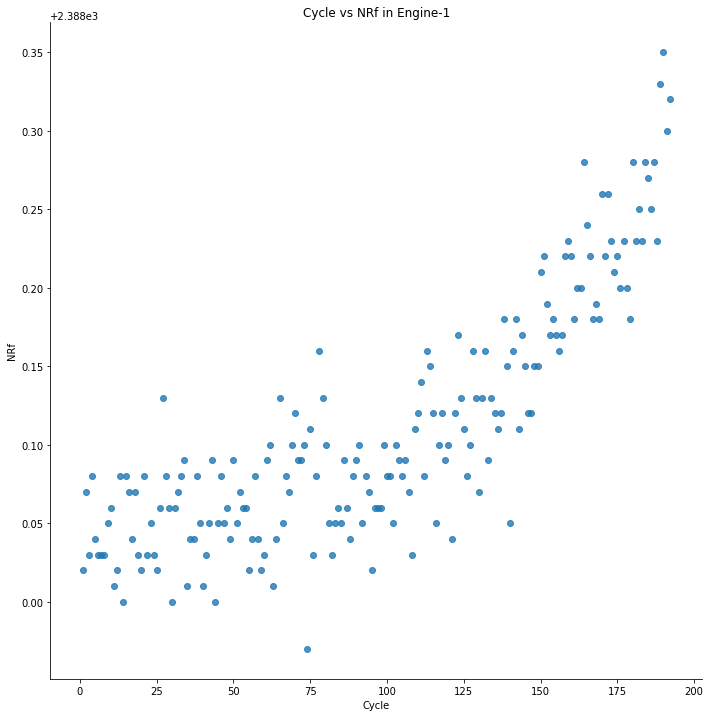

[INFO] figure is saved


In [5]:
ax = cycle_plot(data, 1, 'NRf')
save_plot(ax)

In [6]:
scaled_raw = raw.standardize()
print(scaled_raw.shape)
scaled_raw[:5]

(20631, 26)


array([[-1.72808356, -1.56517022, -0.31597968, -1.3729532 ,  0.        ,
         0.        , -1.72172539, -0.13425518, -0.92593596, -1.        ,
         0.14168333,  1.12114057, -0.51633841, -0.86281332,  0.        ,
        -0.2664666 ,  0.33426184, -1.05889024, -0.26907104, -0.6038157 ,
        -1.        , -0.78170979,  0.        ,  0.        ,  1.34849274,
         1.19442705],
       [-1.72808356, -1.55065208,  0.87272193, -1.03172035,  0.        ,
         0.        , -1.06177971,  0.21152849, -0.64372587, -1.        ,
         0.14168333,  0.43193018, -0.798093  , -0.95881761,  0.        ,
        -0.19158293,  1.17489932, -0.363646  , -0.64284474, -0.27585181,
        -1.        , -0.78170979,  0.        ,  0.        ,  1.01652793,
         1.23692196],
       [-1.72808356, -1.53613393, -1.96187421,  1.01567674,  0.        ,
         0.        , -0.66181262, -0.41316559, -0.52595315, -1.        ,
         0.14168333,  1.00815526, -0.23458381, -0.55713925,  0.        ,
       

In [13]:
class NN(nn.Module):
    """Neural Network Generator."""
    def __init__(self, input_size=24, hidden_sizes=[20,15], output_size=1, drop_p=0.4):
        """Generate fully-connected neural network.

        parameters
        ----------
        input_size (int): size of the input
        hidden_sizes (list of int): size of the hidden layers
        output_layer (int): size of the output layer
        drop_p (float): dropout probability
        """
        super().__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_sizes[0])
        ])
        layers = zip(hidden_sizes[:-1], hidden_sizes[1:])
        self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in layers])
        self.output = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(drop_p)
    
    def forward(self, X):
        for index, linear in enumerate(self.hidden_layers):
            if index % 2 == 0:
                X = linear(X)
                X = self.dropout(X)
            elif index % 2 != 0:
                X = torch.tanh(linear(X))
        
        X = self.output(X)

        return F.relu(X)

In [38]:
model = NN(hidden_sizes=[24, 10])
model

NN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=24, out_features=24, bias=True)
    (1): Linear(in_features=24, out_features=10, bias=True)
  )
  (output): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.4)
)

In [26]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-7.1143e-02, -7.3430e-02, -3.0977e-02,  9.2739e-02, -1.8801e-01,
          1.5223e-01, -5.0554e-02,  7.6459e-02,  7.3142e-02,  2.4187e-02,
          1.5516e-01, -2.1548e-02,  1.8929e-01,  9.6096e-02, -1.3130e-01,
         -1.1802e-01,  9.5124e-03, -1.4601e-01,  6.6404e-02, -2.0171e-02,
         -6.3556e-03, -1.3996e-01, -7.2078e-02,  4.7393e-02],
        [-2.6084e-03,  1.6199e-02, -1.0984e-01, -5.1767e-02,  1.9739e-01,
         -1.4952e-01, -1.7496e-01,  1.4858e-01,  9.1671e-02, -1.2103e-01,
          1.1901e-01, -6.9988e-02,  1.7554e-01, -1.0293e-01,  4.7561e-02,
          1.3348e-01, -4.9979e-02, -3.9201e-02, -1.8800e-01, -3.0802e-02,
          5.4438e-02,  1.5493e-01,  2.0072e-01,  8.4845e-02],
        [ 1.8276e-01, -1.2165e-01,  4.9307e-02,  5.3011e-02, -1.4169e-01,
         -5.7339e-02, -1.1851e-02, -1.7536e-01, -1.5572e-02, -5.9955e-02,
          8.9461e-02,  3.5372e-02, -7.9280e-02,  3.1429e-02,  6.0229e-02,
          1.9308e-01,  1.5943e-01,  8.03

In [27]:
def training(
    model,
    criterion,
    optimizer,
    featureloader,
    labelloader,
    epochs=5,
    print_every=40
):
    epoch_loss = 0
    steps = 0
    1
    for epoch in range(epochs):
        for features, labels in zip(featureloader, labelloader):
            steps += 1
            features, labels = features.type(torch.FloatTensor), labels.type(torch.FloatTensor)
            labels.resize_(labels.shape[0], 1)
            
            output = model.forward(features)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if steps % print_every == 0:
                print('Epoch: {}/{}..'.format(epoch+1, epochs),
                      'Training loss: {:.3f}'.format(epoch_loss/print_every))

                epoch_loss = 0

In [39]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [40]:
featureset.shape

torch.Size([20631, 24])

In [41]:
featureset = torch.from_numpy(scaled_raw[:,2:])
labelset = torch.from_numpy(raw.target)

featureloader = torch.utils.data.DataLoader(featureset, batch_size=32)
labelloader = torch.utils.data.DataLoader(labelset, batch_size=32)

In [65]:
model = NN(hidden_sizes=[30, 15])

optimizer = optim.RMSprop(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

training(model, criterion, optimizer, featureloader, labelloader, epochs=100, print_every=50)

Epoch: 1/100.. Training loss: 16909.851
Epoch: 1/100.. Training loss: 11363.752
Epoch: 1/100.. Training loss: 11295.594
Epoch: 1/100.. Training loss: 9072.098
Epoch: 1/100.. Training loss: 7857.110
Epoch: 1/100.. Training loss: 10524.231
Epoch: 1/100.. Training loss: 10896.970
Epoch: 1/100.. Training loss: 8121.215
Epoch: 1/100.. Training loss: 15541.844
Epoch: 1/100.. Training loss: 7254.205
Epoch: 1/100.. Training loss: 11748.486
Epoch: 1/100.. Training loss: 10489.483
Epoch: 2/100.. Training loss: 10459.455
Epoch: 2/100.. Training loss: 8864.036
Epoch: 2/100.. Training loss: 6347.583
Epoch: 2/100.. Training loss: 5402.298
Epoch: 2/100.. Training loss: 4103.582
Epoch: 2/100.. Training loss: 3587.880
Epoch: 2/100.. Training loss: 5480.083
Epoch: 2/100.. Training loss: 5649.137
Epoch: 2/100.. Training loss: 4765.783
Epoch: 2/100.. Training loss: 9859.831
Epoch: 2/100.. Training loss: 3888.400
Epoch: 2/100.. Training loss: 6863.742
Epoch: 2/100.. Training loss: 7650.365
Epoch: 3/100.. T

Epoch: 17/100.. Training loss: 697.724
Epoch: 17/100.. Training loss: 2209.738
Epoch: 17/100.. Training loss: 4424.556
Epoch: 17/100.. Training loss: 1346.405
Epoch: 17/100.. Training loss: 1900.212
Epoch: 17/100.. Training loss: 2403.243
Epoch: 17/100.. Training loss: 2875.736
Epoch: 18/100.. Training loss: 1693.934
Epoch: 18/100.. Training loss: 880.126
Epoch: 18/100.. Training loss: 1496.069
Epoch: 18/100.. Training loss: 1033.338
Epoch: 18/100.. Training loss: 967.520
Epoch: 18/100.. Training loss: 1112.501
Epoch: 18/100.. Training loss: 694.805
Epoch: 18/100.. Training loss: 2179.571
Epoch: 18/100.. Training loss: 4463.037
Epoch: 18/100.. Training loss: 1305.730
Epoch: 18/100.. Training loss: 1819.365
Epoch: 18/100.. Training loss: 2818.057
Epoch: 18/100.. Training loss: 2450.047
Epoch: 19/100.. Training loss: 1518.818
Epoch: 19/100.. Training loss: 863.744
Epoch: 19/100.. Training loss: 1531.667
Epoch: 19/100.. Training loss: 1099.628
Epoch: 19/100.. Training loss: 1016.535
Epoch

Epoch: 33/100.. Training loss: 2081.169
Epoch: 33/100.. Training loss: 3021.081
Epoch: 34/100.. Training loss: 2390.568
Epoch: 34/100.. Training loss: 1137.470
Epoch: 34/100.. Training loss: 1263.419
Epoch: 34/100.. Training loss: 1046.116
Epoch: 34/100.. Training loss: 1166.257
Epoch: 34/100.. Training loss: 1000.552
Epoch: 34/100.. Training loss: 786.307
Epoch: 34/100.. Training loss: 1896.705
Epoch: 34/100.. Training loss: 3030.295
Epoch: 34/100.. Training loss: 2858.054
Epoch: 34/100.. Training loss: 1176.832
Epoch: 34/100.. Training loss: 2072.861
Epoch: 34/100.. Training loss: 4026.846
Epoch: 35/100.. Training loss: 1597.164
Epoch: 35/100.. Training loss: 999.055
Epoch: 35/100.. Training loss: 1279.395
Epoch: 35/100.. Training loss: 1058.445
Epoch: 35/100.. Training loss: 1176.633
Epoch: 35/100.. Training loss: 987.451
Epoch: 35/100.. Training loss: 849.142
Epoch: 35/100.. Training loss: 1891.187
Epoch: 35/100.. Training loss: 3008.017
Epoch: 35/100.. Training loss: 3058.711
Epoc

Epoch: 50/100.. Training loss: 1576.593
Epoch: 50/100.. Training loss: 887.057
Epoch: 50/100.. Training loss: 1431.634
Epoch: 50/100.. Training loss: 1362.546
Epoch: 50/100.. Training loss: 960.232
Epoch: 50/100.. Training loss: 1039.364
Epoch: 50/100.. Training loss: 1225.459
Epoch: 50/100.. Training loss: 2153.997
Epoch: 50/100.. Training loss: 4042.770
Epoch: 50/100.. Training loss: 1282.950
Epoch: 50/100.. Training loss: 2344.869
Epoch: 50/100.. Training loss: 2657.739
Epoch: 50/100.. Training loss: 2326.566
Epoch: 51/100.. Training loss: 1515.752
Epoch: 51/100.. Training loss: 1250.661
Epoch: 51/100.. Training loss: 1193.374
Epoch: 51/100.. Training loss: 1235.575
Epoch: 51/100.. Training loss: 962.050
Epoch: 51/100.. Training loss: 1029.015
Epoch: 51/100.. Training loss: 1399.776
Epoch: 51/100.. Training loss: 1984.376
Epoch: 51/100.. Training loss: 4153.730
Epoch: 51/100.. Training loss: 1438.888
Epoch: 51/100.. Training loss: 2190.382
Epoch: 51/100.. Training loss: 2852.643
Epo

Epoch: 66/100.. Training loss: 1150.018
Epoch: 66/100.. Training loss: 1483.413
Epoch: 66/100.. Training loss: 1001.801
Epoch: 66/100.. Training loss: 1029.444
Epoch: 66/100.. Training loss: 1064.149
Epoch: 66/100.. Training loss: 886.576
Epoch: 66/100.. Training loss: 2043.713
Epoch: 66/100.. Training loss: 3041.566
Epoch: 66/100.. Training loss: 2933.496
Epoch: 66/100.. Training loss: 1600.603
Epoch: 66/100.. Training loss: 2145.588
Epoch: 66/100.. Training loss: 3516.022
Epoch: 67/100.. Training loss: 1858.524
Epoch: 67/100.. Training loss: 916.650
Epoch: 67/100.. Training loss: 1511.727
Epoch: 67/100.. Training loss: 1071.753
Epoch: 67/100.. Training loss: 1112.083
Epoch: 67/100.. Training loss: 1116.396
Epoch: 67/100.. Training loss: 768.634
Epoch: 67/100.. Training loss: 2228.314
Epoch: 67/100.. Training loss: 4557.872
Epoch: 67/100.. Training loss: 1281.342
Epoch: 67/100.. Training loss: 2031.658
Epoch: 67/100.. Training loss: 2422.704
Epoch: 67/100.. Training loss: 2992.751
Epo

Epoch: 82/100.. Training loss: 1245.826
Epoch: 82/100.. Training loss: 879.748
Epoch: 82/100.. Training loss: 1103.241
Epoch: 82/100.. Training loss: 1622.288
Epoch: 82/100.. Training loss: 2134.050
Epoch: 82/100.. Training loss: 3799.333
Epoch: 82/100.. Training loss: 1371.840
Epoch: 82/100.. Training loss: 2169.891
Epoch: 82/100.. Training loss: 3167.864
Epoch: 83/100.. Training loss: 2343.029
Epoch: 83/100.. Training loss: 1053.556
Epoch: 83/100.. Training loss: 1402.673
Epoch: 83/100.. Training loss: 1179.309
Epoch: 83/100.. Training loss: 1258.358
Epoch: 83/100.. Training loss: 809.281
Epoch: 83/100.. Training loss: 1040.709
Epoch: 83/100.. Training loss: 1777.803
Epoch: 83/100.. Training loss: 2062.461
Epoch: 83/100.. Training loss: 4004.299
Epoch: 83/100.. Training loss: 1282.868
Epoch: 83/100.. Training loss: 2140.922
Epoch: 83/100.. Training loss: 3108.373
Epoch: 84/100.. Training loss: 2374.062
Epoch: 84/100.. Training loss: 1118.943
Epoch: 84/100.. Training loss: 1288.816
Ep

Epoch: 98/100.. Training loss: 1203.020
Epoch: 98/100.. Training loss: 708.075
Epoch: 98/100.. Training loss: 2186.924
Epoch: 98/100.. Training loss: 4657.388
Epoch: 98/100.. Training loss: 1239.507
Epoch: 98/100.. Training loss: 1830.240
Epoch: 98/100.. Training loss: 2793.375
Epoch: 98/100.. Training loss: 2464.966
Epoch: 99/100.. Training loss: 1585.563
Epoch: 99/100.. Training loss: 898.809
Epoch: 99/100.. Training loss: 1558.345
Epoch: 99/100.. Training loss: 1247.875
Epoch: 99/100.. Training loss: 1034.777
Epoch: 99/100.. Training loss: 1007.746
Epoch: 99/100.. Training loss: 720.199
Epoch: 99/100.. Training loss: 2109.137
Epoch: 99/100.. Training loss: 4895.103
Epoch: 99/100.. Training loss: 1313.540
Epoch: 99/100.. Training loss: 1779.747
Epoch: 99/100.. Training loss: 2954.078
Epoch: 99/100.. Training loss: 2603.010
Epoch: 100/100.. Training loss: 1474.042
Epoch: 100/100.. Training loss: 879.280
Epoch: 100/100.. Training loss: 1399.279
Epoch: 100/100.. Training loss: 1300.541


In [66]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1508,  0.1116,  0.1067, -0.1962,  0.3717,  0.2708,  0.3213, -1.3317,
         -0.1024, -0.3320,  0.4663,  0.6533,  0.1071,  0.8629, -0.8526,  0.3096,
          0.4353, -0.0418, -1.6303,  0.7298, -0.1991,  0.1517, -0.2207, -0.4123],
        [ 0.2594,  0.0228, -0.1904,  0.0450,  0.2800,  0.5958,  0.5181,  0.8084,
         -0.7581, -0.6571,  0.8008,  0.1153,  0.0067,  0.5632, -0.2421,  0.8394,
         -0.4086,  0.2528,  0.8038,  0.1209,  0.0834,  0.0516, -0.0973, -0.3190],
        [-0.1005, -0.1669,  0.1688, -0.0156,  0.2320, -0.4707,  0.3908,  0.5735,
         -0.4592, -0.3241,  0.6081,  1.3575, -0.1406,  0.3307, -0.5829, -0.1431,
          2.5006,  0.3831,  0.2938,  0.0314, -0.0466, -0.0469, -0.1101, -0.2619],
        [-0.2211, -0.0815, -0.0201, -0.1794, -0.4260, -0.3989, -0.6235, -1.0338,
          0.3433,  0.2787, -0.7507, -0.1301, -0.0221, -0.7762,  0.5694, -0.8800,
         -0.0156, -0.5715, -1.0808, -0.1436,  0.0518, -0.0729,  0.4691,  0.3457],
  

In [ ]:
infer = torch.from_numpy(scaled_raw[:, 2:])
outputs = model(inf.type(torch.DoubleTensor))

In [67]:
inf = torch.from_numpy(scaled_raw[0,2:])
target = torch.from_numpy(raw.target[0].reshape(1,1))
output = model(inf.type(torch.FloatTensor))
print(criterion(target.type(torch.DoubleTensor), output.type(torch.DoubleTensor)))
print(output, target)

tensor(823.3343, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([162.3062], grad_fn=<ThAddBackward>) tensor([[191.]], dtype=torch.float64)
